# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from sklearn.neighbors import KNeighborsRegressor
import time
import datetime
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/Shareddrives/Machine Learning - Transformers/

/content/drive/Shareddrives/Machine Learning - Transformers


# Utils

In [ ]:
def create_X_y(df):
  y = df['PM25_Concentration'].copy()
  X = df.drop('PM25_Concentration', axis=1).copy()
  return X,y

# Clean Data

In [ ]:
def convertTime(df):
  df1 = df.copy()
  time_series = pd.Series(np.arange(start = 1, stop = df1.shape[0] + 1, step = 1), copy = False)
  df1['time'] = time_series
  return df1

In [ ]:
def remove(df, time=False):
  if time:
    cols = ['time', 'station_id', 'district_id']
  else:
    cols = ['station_id', 'district_id']

  df1 = df.copy()
  return df1.drop(cols, axis=1)

In [ ]:
def clean(df, time=False):
  df1 = convertTime(df)
  df1 = remove(df1, time=time)
  return df1

#Creating dictionary to store results of the baselines

In [ ]:
results = {}
results_mm = {}
results_std = {}

In [ ]:
import seaborn as sns

In [ ]:
def plot(y_test, preds, path="", save=False, n=100):
    y_test = y_test.copy()
    y_test['pred'] = preds
    y_new = y_test.sort_index(axis = 0)
    # print(y_new)
    y = y_new["PM25_Concentration"].to_numpy()[:n]
    preds = y_new["pred"].to_numpy()[:n]
    plt.figure(figsize=(20,7))
    plt.tight_layout()
    plt.plot(y_new.index[:len(y)], y, label="y_test")
    plt.plot(y_new.index[:len(y)], preds, label="y_hat")
    plt.xlabel("Time")
    plt.ylabel("PM 2.5 Concentration")
    plt.legend()
    sns.despine()
    if save:
        plt.savefig(path)
    return plt

# KNN - Uniform Distance

##General function for KNN

In [ ]:
def runKNN(X_train, X_test, y_train, y_test, n_neighbors=3, fold=0):
  '''
  runs KNN with default neighbors=3
  Returns:
  preds for given X_test, rmse
  '''
  neigh = KNeighborsRegressor(n_neighbors = n_neighbors)
  neigh.fit(X_train,y_train)
  score = neigh.score(X_test, y_test)
  preds = neigh.predict(X_test)
  rmse = (np.square(np.subtract(y_test,preds)).mean()) ** 0.5
  print(f"fold {fold} \t RMSE: {rmse}")
  return preds, rmse

##Running on Unscaled data

In [ ]:
mean = 0

for fold in [0,1,2]:
  train_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_train.csv')
  test_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_test.csv')
  train_data = clean(train_data)
  test_data = clean(test_data)
  X_train, y_train = create_X_y(train_data)
  X_test, y_test = create_X_y(test_data)
  preds, rmse = runKNN(X_train, X_test, y_train, y_test, fold=fold)
  mean+=rmse
mean /= 3
print(f"mean rmse: {mean}")
results['KNN'] = mean

fold 0 	 RMSE: 40.577372361082396
fold 1 	 RMSE: 45.198616399263614
fold 2 	 RMSE: 48.22364145458525
mean rmse: 44.666543404977084


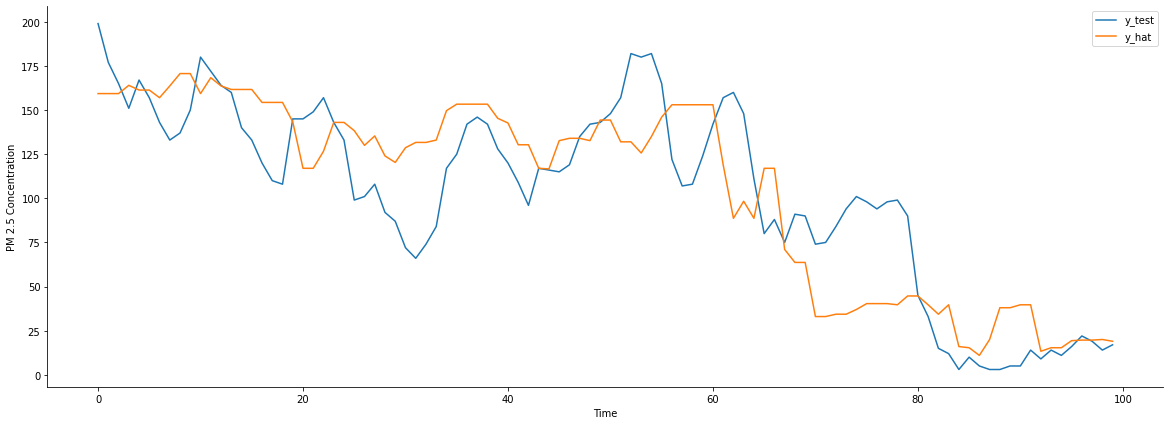

In [ ]:
fig= plot(pd.DataFrame(y_test), preds, "Plots/baselines/knn_unscaled.png", 1000)
fig.show()

##Scaled using mm

In [ ]:
mean = 0
for fold in [0,1,2]:
  train_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_train_mm.csv')
  test_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_test_mm.csv')
  train_data = clean(train_data)
  test_data = clean(test_data)
  X_train, y_train = create_X_y(train_data)
  X_test, y_test = create_X_y(test_data)
  preds, rmse = runKNN(X_train, X_test, y_train, y_test, fold=fold)
  mean+=rmse
mean /= 3
print(f"mean rmse: {mean}")
results_mm["KNN"] = mean

fold 0 	 RMSE: 44.74346364402022
fold 1 	 RMSE: 47.07434658989143
fold 2 	 RMSE: 50.73245768139246
mean rmse: 47.51675597176804


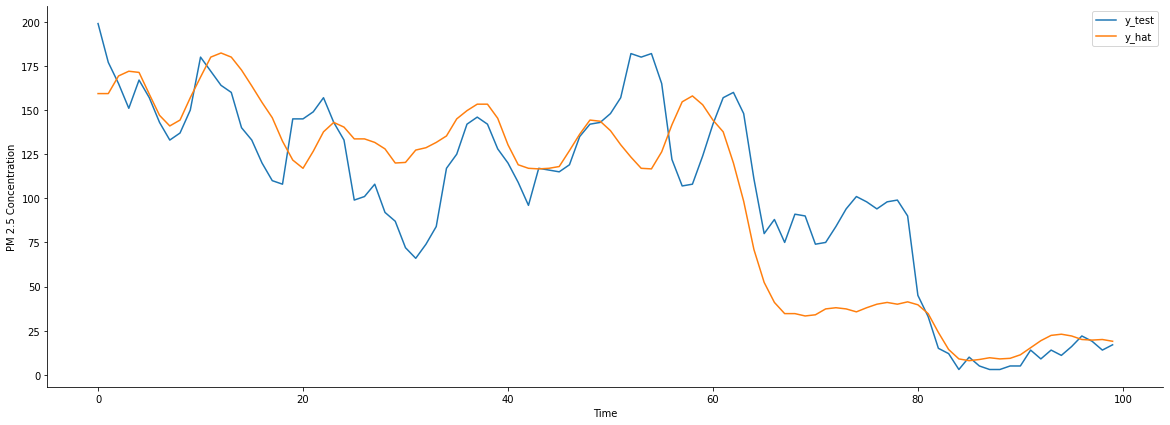

In [ ]:
fig= plot(pd.DataFrame(y_test), preds, "Plots/baselines/knn_mm", 1000)
fig.show()

##Scaled using std

In [ ]:
mean = 0
for fold in [0,1,2]:
  train_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_train_std.csv')
  test_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_test_std.csv')
  train_data = clean(train_data)
  test_data = clean(test_data)
  X_train, y_train = create_X_y(train_data)
  X_test, y_test = create_X_y(test_data)
  preds, rmse = runKNN(X_train, X_test, y_train, y_test, fold=fold)
  mean+=rmse
mean /= 3
print(f"mean rmse: {mean}")
results_std["KNN"] = mean

fold 0 	 RMSE: 44.55188211992045
fold 1 	 RMSE: 47.01169812449515
fold 2 	 RMSE: 50.75924929579799
mean rmse: 47.440943180071194


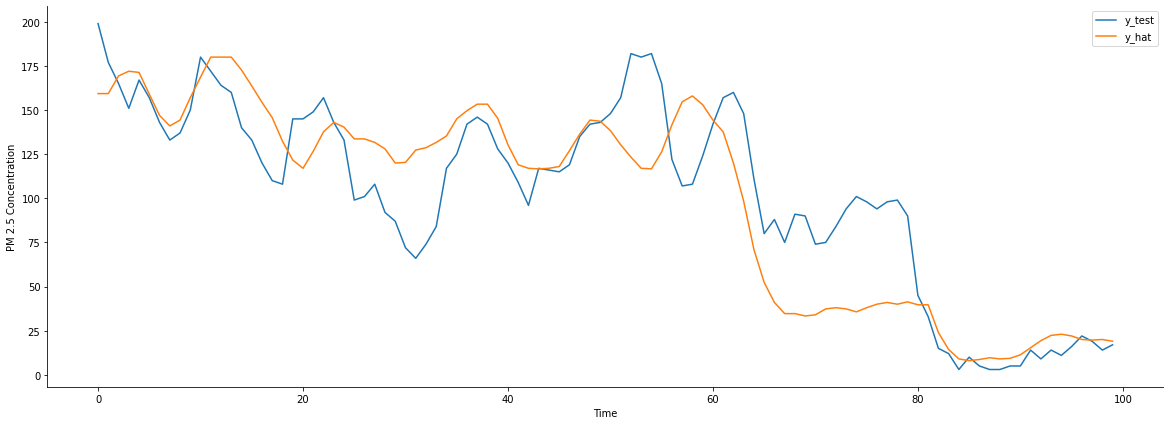

In [ ]:
fig= plot(pd.DataFrame(y_test), preds, "Plots/baselines/knn_std", 1000)
fig.show()

# Random Forest Regressor

##General function for RF

In [ ]:
def runRF(X_train, X_test, y_train, y_test, max_depth=6, fold=0):
  '''
  runs RF with default max_depth=2
  Returns:
  preds for given X_test, rmse
  '''
  regr = RandomForestRegressor(max_depth=max_depth, random_state=0)
  y_train_regr = y_train.to_numpy().ravel()
  y_test_regr = y_test.to_numpy().ravel()
  regr.fit(X_train, y_train_regr)
  preds = regr.predict(X_test)
  rmse = (np.square(np.subtract(y_test_regr,preds)).mean()) ** 0.5
  print(f"fold {fold} \t RMSE: {rmse}")
  return preds, rmse

##Unscaled data

In [ ]:
mean = 0
preds = []
y_test_lst = []
for fold in [0,1,2]:
  train_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_train.csv')
  test_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_test.csv')

  train_data = clean(train_data)
  test_data = clean(test_data)
  X_train, y_train = create_X_y(train_data)
  X_test, y_test = create_X_y(test_data)
  y_test_lst.append(y_test)
  pred, rmse = runRF(X_train, X_test, y_train, y_test, fold=fold)
  preds.append(pred)
  mean+=rmse
mean /= 3
print(f"mean rmse: {mean}")
results["RF"] = mean

fold 0 	 RMSE: 32.4994871884315
fold 1 	 RMSE: 32.23898740188381
fold 2 	 RMSE: 29.346224797429553
mean rmse: 31.361566462581624


In [ ]:
data = clean(final_new_interpolated)
X_data, y_data = create_X_y(data)
regr = RandomForestRegressor()
clf = GridSearchCV(regr, param_grid={"max_depth": [6,8,10,12,14,16], "random_state":[0], "n_estimators":[50,100,200]}, verbose=1, n_jobs=-1, cv=2)
clf.fit(X_data, y_data)

Fitting 2 folds for each of 18 candidates, totalling 36 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=2, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10, 12, 14, 16],
                         'n_estimators': [50, 100, 200], 'random_state': [0]},
             verbose=1)

In [ ]:
resultdf = pd.DataFrame(clf.cv_results_)
resultdf

In [ ]:
clf.best_params_

{'max_depth': 6, 'n_estimators': 200, 'random_state': 0}

In [ ]:
test_data0 = pd.read_csv('Data/interpolated/fold_0_test.csv')
test_data1 = pd.read_csv('Data/interpolated/fold_1_test.csv')
test_data2 = pd.read_csv('Data/interpolated/fold_2_test.csv')
stations0 = np.unique(test_data0['statiaon_id'])
stations1 = np.unique(test_data1['station_id'])
stations2 = np.unique(test_data2['station_id'])

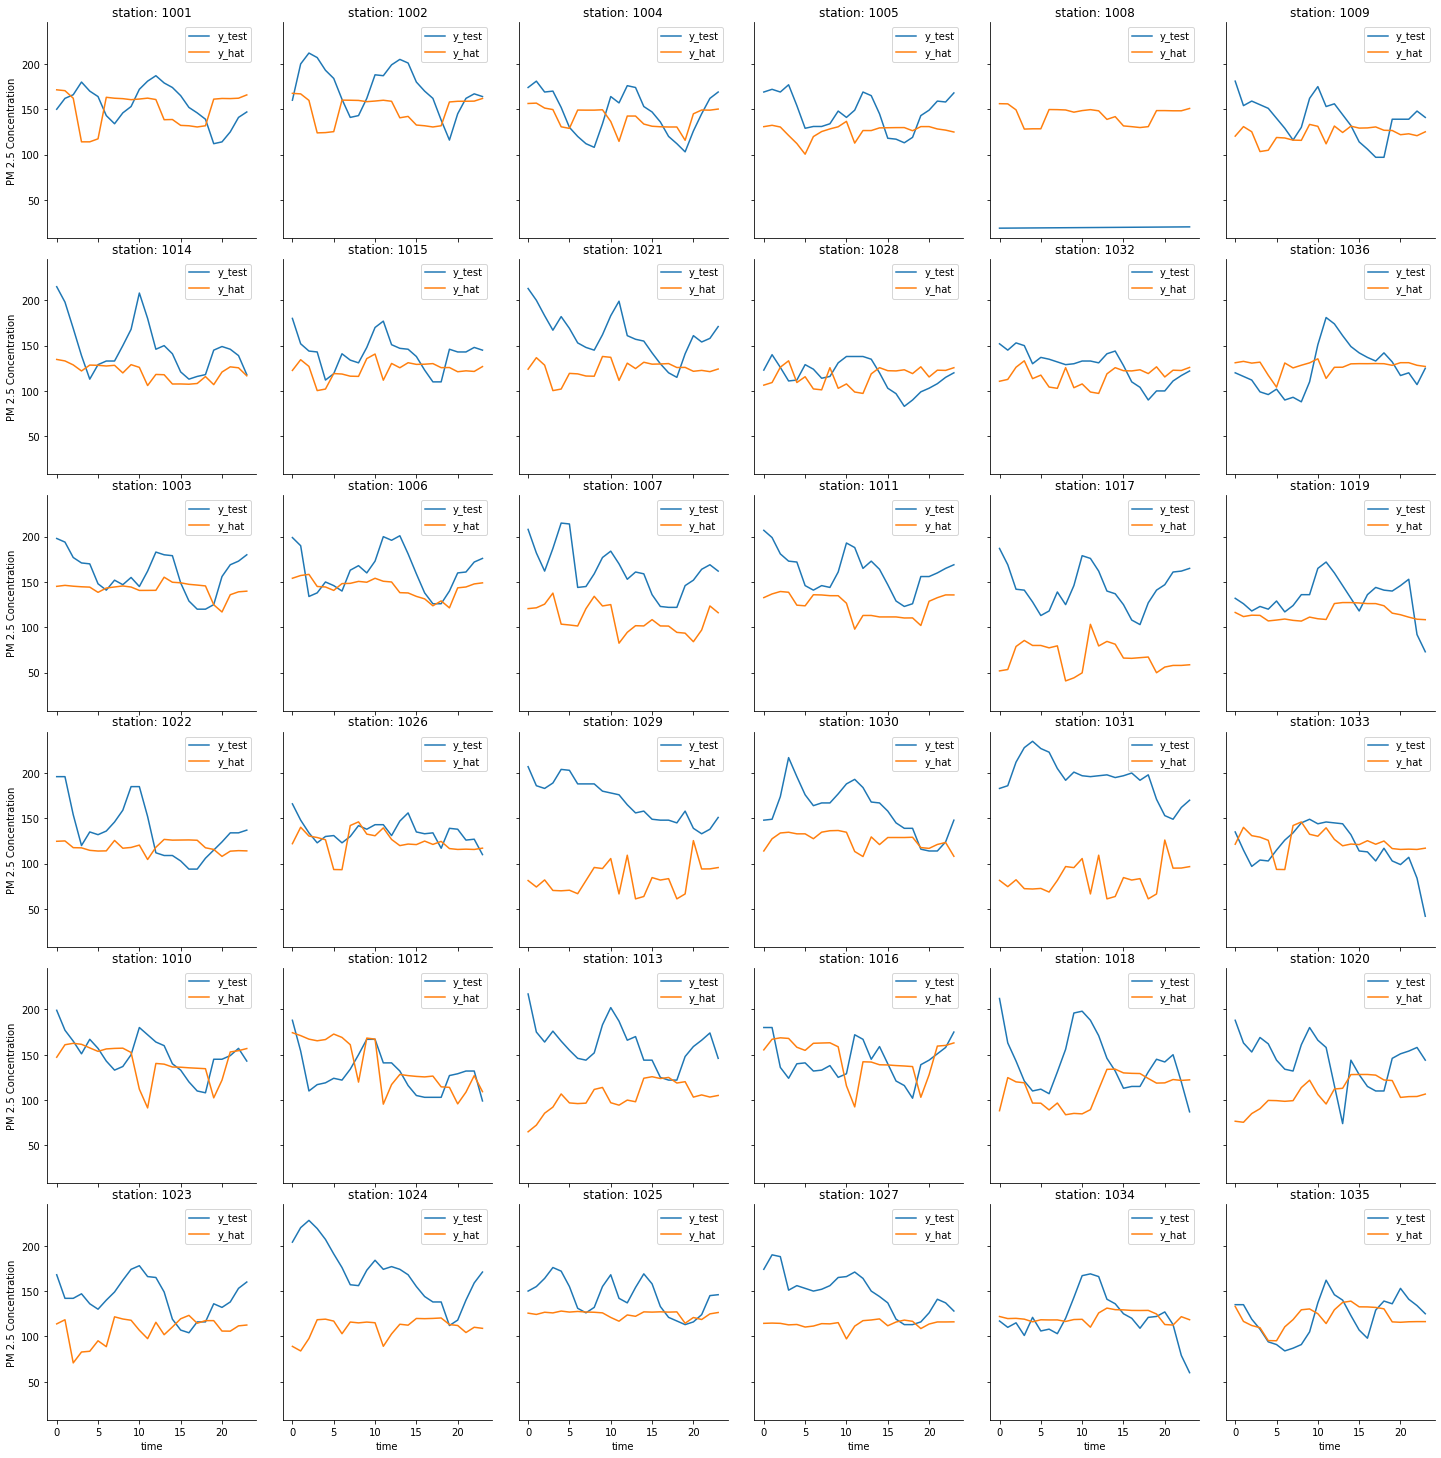

In [ ]:
y_test = pd.DataFrame(y_test)
m = 0
n = 24
fig, ax = plt.subplots(6,6, sharex=True, sharey=True, figsize=(20,20))
fig.tight_layout()
i = 0
for r in range(6):
    for c in range(6):
        if i<12:
            y_test = pd.DataFrame(y_test_lst[0][test_data0['station_id']==stations0[i]])
            pred = preds[0][test_data0['station_id']==stations0[i]]
            y_test['pred']=pred
            y_test.sort_index(axis=0)
            y_test.reset_index(drop=True, inplace=True)
            y = y_test["PM25_Concentration"].to_numpy()[m:n]
            pr = y_test["pred"].to_numpy()[m:n]
            ax[r,c].plot(y_test.index[m:n], y, label="y_test")
            ax[r,c].plot(y_test.index[m:n], pr, label="y_hat")
            ax[r,c].set_title(f"station: {stations0[i]}")
            ax[r,c].legend()
            # ax[r,c].legend(bbox_to_anchor=(1.2,1))
        elif i<24:
            y_test = pd.DataFrame(y_test_lst[1][test_data1['station_id']==stations1[i-12]])
            pred = preds[1][test_data1['station_id']==stations1[i-12]]
            y_test['pred']=pred
            y_test.sort_index(axis=0)
            y_test.reset_index(drop=True, inplace=True)
            y = y_test["PM25_Concentration"].to_numpy()[m:n]
            pr = y_test["pred"].to_numpy()[m:n]
            ax[r,c].plot(y_test.index[m:n], y, label="y_test")
            ax[r,c].plot(y_test.index[m:n], pr, label="y_hat")
            ax[r,c].set_title(f"station: {stations1[i-12]}")
            ax[r,c].legend()
        else:
            y_test = pd.DataFrame(y_test_lst[2][test_data2['station_id']==stations2[i-24]])
            pred = preds[2][test_data2['station_id']==stations2[i-24]]
            y_test['pred']=pred
            y_test.sort_index(axis=0)
            y_test.reset_index(drop=True, inplace=True)
            y = y_test["PM25_Concentration"].to_numpy()[m:n]
            pr = y_test["pred"].to_numpy()[m:n]
            ax[r,c].plot(y_test.index[m:n], y, label="y_test")
            ax[r,c].plot(y_test.index[m:n], pr, label="y_hat")
            ax[r,c].set_title(f"station: {stations2[i-24]}")
            ax[r,c].legend()
        i+=1
for a in ax.flat:
    a.set(xlabel='time', ylabel='PM 2.5 Concentration')

for a in ax.flat:
    a.label_outer()
sns.despine()

In [ ]:
fig.savefig(f"Plots/rf_station_wise_{m}_{n}.png")

##Scaled using mm

In [ ]:
mean = 0
for fold in [0,1,2]:
  train_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_train_mm.csv')
  test_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_test_mm.csv')
  train_data = clean(train_data)
  test_data = clean(test_data)
  X_train, y_train = create_X_y(train_data)
  X_test, y_test = create_X_y(test_data)
  preds, rmse = runRF(X_train, X_test, y_train, y_test, fold=fold)
  mean+=rmse
mean /= 3
print(f"mean rmse: {mean}")
results_mm["RF"] = mean

fold 0 	 RMSE: 32.50749269358885
fold 1 	 RMSE: 32.24529765906472
fold 2 	 RMSE: 29.347753351898223
mean rmse: 31.36684790151726


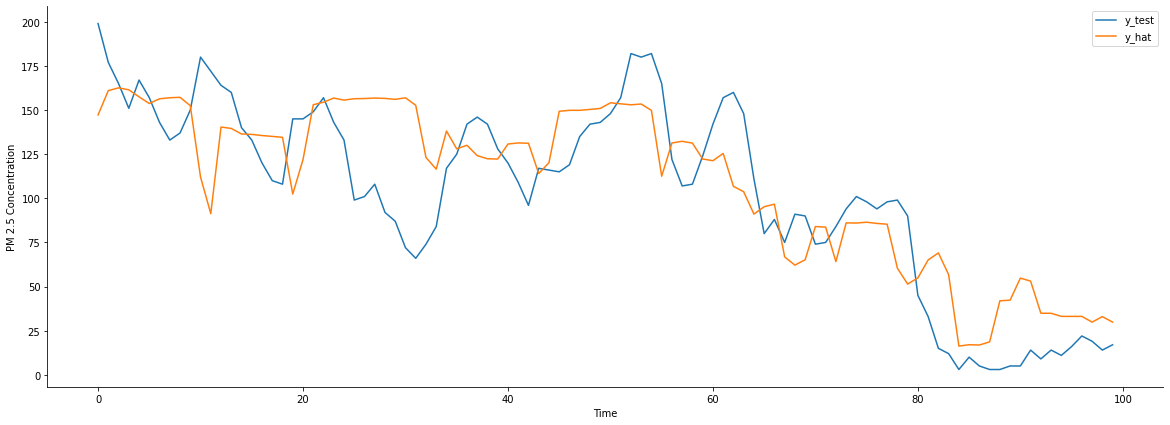

In [ ]:
fig= plot(pd.DataFrame(y_test), preds, "Plots/baselines/rf_mm", 1000)
fig.show()

##Scaled using std

In [ ]:
mean = 0
for fold in [0,1,2]:
  train_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_train_std.csv')
  test_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_test_std.csv')
  train_data = clean(train_data)
  test_data = clean(test_data)
  X_train, y_train = create_X_y(train_data)
  X_test, y_test = create_X_y(test_data)
  preds, rmse = runRF(X_train, X_test, y_train, y_test, fold=fold)
  mean+=rmse
mean /= 3
print(f"mean rmse: {mean}")
results_std["RF"] = mean

fold 0 	 RMSE: 32.5006094423727
fold 1 	 RMSE: 32.2395945761756
fold 2 	 RMSE: 29.34727812500685
mean rmse: 31.362494047851715


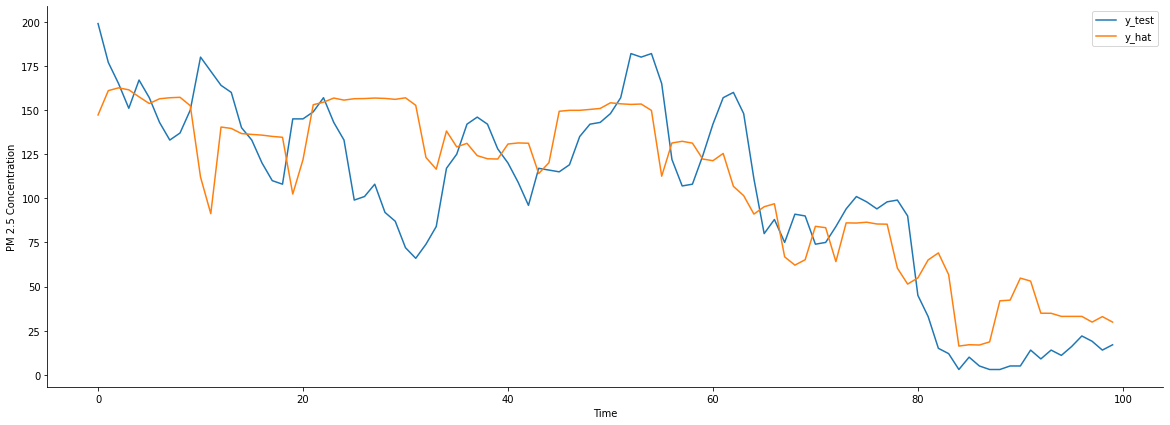

In [ ]:
fig= plot(pd.DataFrame(y_test), preds, "Plots/baselines/rf_std", 1000)
fig.show()

# LINEAR

##General function for Linear

In [ ]:
def runLR(X_train, X_test, y_train, y_test, fold=0):
  '''
  runs PR
  Returns:
  preds for given X_test, rmse
  '''
  lin_reg = LinearRegression()
  lin_reg.fit(X_train, y_train)
  preds = lin_reg.predict(X_test)
  rmse = np.square(np.subtract(y_test,preds)).mean() ** 0.5
  print(f"fold {fold} \t RMSE: {rmse}")
  return preds, rmse

##Unscaled data

In [ ]:
mean = 0
for fold in [0,1,2]:
  train_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_train.csv')
  test_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_test.csv')

  train_data = clean(train_data)
  test_data = clean(test_data)
  X_train, y_train = create_X_y(train_data)
  X_test, y_test = create_X_y(test_data)
  preds, rmse = runLR(X_train, X_test, y_train, y_test, fold=fold)
  mean+=rmse
mean /= 3
print(f"mean rmse: {mean}")
results["LR"] = mean

fold 0 	 RMSE: 39.74346656969112
fold 1 	 RMSE: 49.11857222676797
fold 2 	 RMSE: 37.188790944293764
mean rmse: 42.01694324691761


##Scaled using mm

In [ ]:
mean = 0
for fold in [0,1,2]:
  train_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_train_mm.csv')
  test_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_test_mm.csv')

  train_data = clean(train_data)
  test_data = clean(test_data)
  X_train, y_train = create_X_y(train_data)
  X_test, y_test = create_X_y(test_data)
  preds, rmse = runRF(X_train, X_test, y_train, y_test, fold=fold)
  mean+=rmse
mean /= 3
print(f"mean rmse: {mean}")
results_mm['LR'] = mean
  # if (fold == 0):
  #   print(train_data)
  # if (fold == 1):
  #   print(train_data)

fold 0 	 RMSE: 32.50749269358885
fold 1 	 RMSE: 32.24529765906472
fold 2 	 RMSE: 29.347753351898223
mean rmse: 31.36684790151726


##Scaled using std

In [ ]:
mean = 0
for fold in [0,1,2]:
  train_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_train_std.csv')
  test_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_test_std.csv')

  train_data = clean(train_data)
  test_data = clean(test_data)
  X_train, y_train = create_X_y(train_data)
  X_test, y_test = create_X_y(test_data)
  preds, rmse = runRF(X_train, X_test, y_train, y_test, fold=fold)
  mean+=rmse
mean /= 3
print(f"mean rmse: {mean}")
results_std["LR"] = mean
  # if (fold == 0):
  #   print(train_data)

fold 0 	 RMSE: 32.5006094423727
fold 1 	 RMSE: 32.2395945761756
fold 2 	 RMSE: 29.34727812500685
mean rmse: 31.362494047851715


# SVM.SVR (support vector regressor)



##General function for SVM SVR

In [ ]:
# def runSVM(X_train, X_test, y_train, y_test,C=1.0,epsilon=0.2):
#   svr_reg = make_pipeline(SVR(C=1.0, epsilon=0.2))
#   y_train_regr = y_train.to_numpy().ravel()
#   y_test_regr = y_test.to_numpy().ravel()
#   svr_reg.fit(X_train, y_train_regr)
#   svr_reg.score(X_test, y_test_regr)
#   preds = svr_reg.predict(X_test)
#   rmse = np.square(np.subtract(y_test_regr,preds)).mean() ** 0.5
#   print("RMSE: %f" % (rmse))

#   GridSearchCV()


##Unscaled data

In [ ]:
# mean = 0
# for fold in [0,1,2]:
#   train_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_train.csv')
#   test_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_test.csv')
#   cols = ['weather', 'wind_direction']
#   train_data = oneHotEncode(train_data,cols)
#   test_data = oneHotEncode(test_data,cols)
#   train_data = clean(train_data)
#   test_data = clean(test_data)
#   X_train, y_train = create_X_y(train_data)
#   X_test, y_test = create_X_y(test_data)
#   runSVM(X_train, X_test, y_train, y_test)
#   mean+=rmse
# mean /= 3
# print(f"mean rmse: {mean}")
# results["SVR"] = mean

##Scaled using std

In [ ]:
# mean = 0
# for fold in [0,1,2]:
#   train_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_train_std.csv')
#   test_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_test_std.csv')
#   cols = ['weather', 'wind_direction']
#   train_data = oneHotEncode(train_data,cols)
#   test_data = oneHotEncode(test_data,cols)
#   train_data = clean(train_data)
#   test_data = clean(test_data)
#   X_train, y_train = create_X_y(train_data)
#   X_test, y_test = create_X_y(test_data)
#   runSVM(X_train, X_test, y_train, y_test)
#   mean+=rmse
# mean /= 3
# print(f"mean rmse: {mean}")
# results_std["SVR"] = mean

##Scaled data using mm

In [ ]:
# mean = 0
# for fold in [0,1,2]:
#   train_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_train_mm.csv')
#   test_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_test_mm.csv')
#   cols = ['weather', 'wind_direction']
#   train_data = oneHotEncode(train_data,cols)
#   test_data = oneHotEncode(test_data,cols)
#   train_data = clean(train_data)
#   test_data = clean(test_data)
#   X_train, y_train = create_X_y(train_data)
#   X_test, y_test = create_X_y(test_data)
#   runSVM(X_train, X_test, y_train, y_test)
#   mean+=rmse
# mean /= 3
# print(f"mean rmse: {mean}")

# KNN - Inverse Distance (IDW)

##General function for IDW

In [ ]:
def runIDW(X_train, X_test, y_train, y_test, n_neighbors=3, fold=0):
  '''
  runs KNN with default neighbors=3 and inverse distance
  Returns:
  preds for given X_test, rmse
  '''
  neigh = KNeighborsRegressor(n_neighbors = n_neighbors,weights = 'distance')
  neigh.fit(X_train,y_train)
  preds = neigh.predict(X_test)
  rmse = (np.square(np.subtract(y_test,preds)).mean()) ** 0.5
  print(f"fold {fold} \t RMSE: {rmse}")
  return preds, rmse


##Unscaled data

In [ ]:
mean = 0
for fold in [0,1,2]:
  train_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_train.csv')
  test_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_test.csv')

  train_data = clean(train_data)
  test_data = clean(test_data)
  X_train, y_train = create_X_y(train_data)
  X_test, y_test = create_X_y(test_data)
  preds, rmse = runKNN(X_train, X_test, y_train, y_test, fold=fold)
  mean+=rmse
mean /= 3
print(f"mean rmse: {mean}")
results["IDW"] = mean

fold 0 	 RMSE: 40.577372361082396
fold 1 	 RMSE: 45.198616399263614
fold 2 	 RMSE: 48.22364145458525
mean rmse: 44.666543404977084


##Scaled data using mm

In [ ]:
mean = 0
for fold in [0,1,2]:
  train_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_train_mm.csv')
  test_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_test_mm.csv')

  train_data = clean(train_data)
  test_data = clean(test_data)
  X_train, y_train = create_X_y(train_data)
  X_test, y_test = create_X_y(test_data)
  preds, rmse = runKNN(X_train, X_test, y_train, y_test, fold=fold)
  mean+=rmse
mean /= 3
print(f"mean rmse: {mean}")
results_mm["IDW"] = mean

fold 0 	 RMSE: 44.74346364402022
fold 1 	 RMSE: 47.07434658989143
fold 2 	 RMSE: 50.73245768139246
mean rmse: 47.51675597176804


##Scaled using std

In [ ]:
mean = 0
for fold in [0,1,2]:
  train_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_train_std.csv')
  test_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_test_std.csv')
  
  train_data = clean(train_data)
  test_data = clean(test_data)
  X_train, y_train = create_X_y(train_data)
  X_test, y_test = create_X_y(test_data)
  preds, rmse = runKNN(X_train, X_test, y_train, y_test, fold=fold)
  mean+=rmse
mean /= 3
print(f"mean rmse: {mean}")
results_std["IDW"] = mean

fold 0 	 RMSE: 44.55188211992045
fold 1 	 RMSE: 47.01169812449515
fold 2 	 RMSE: 50.75924929579799
mean rmse: 47.440943180071194


# XGBoost

##General function for XGBoost

In [ ]:
def runXGB(X_train, X_test, y_train, y_test):
  y_train_regr = y_train.to_numpy().ravel()
  y_test_regr = y_test.to_numpy().ravel() 
  clf = GradientBoostingRegressor(random_state=0).fit(X_train, y_train_regr)
  preds = clf.predict(X_test)
  rmse =  mean_squared_error(y_test_regr, preds) ** 0.5
  print("RMSE: %f" % (rmse))
  return preds, rmse

##Unscaled data

In [ ]:
mean = 0
for fold in [0,1,2]:
  train_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_train.csv')
  test_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_test.csv')
  
  train_data = clean(train_data)
  test_data = clean(test_data)
  X_train, y_train = create_X_y(train_data)
  X_test, y_test = create_X_y(test_data)
  preds, rmse = runXGB(X_train,X_test,y_train,y_test)
  mean+=rmse
mean /= 3
print(f"mean rmse: {mean}")
results["XGBoost"] = mean

RMSE: 36.869116
RMSE: 37.804213
RMSE: 32.283264
mean rmse: 35.65219749461114


##Scaled using mm

In [ ]:
mean = 0
for fold in [0,1,2]:
  train_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_train_mm.csv')
  test_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_test_mm.csv')

  train_data = clean(train_data)
  test_data = clean(test_data)
  X_train, y_train = create_X_y(train_data)
  X_test, y_test = create_X_y(test_data)
  preds, rmse = runXGB(X_train,X_test,y_train,y_test)
  mean+=rmse
mean /= 3
print(f"mean rmse: {mean}")
results_mm["XGBoost"] = mean

RMSE: 36.827790
RMSE: 38.413400
RMSE: 32.283264
mean rmse: 35.84148497034074


##Scaled using std

In [ ]:
mean = 0
for fold in [0,1,2]:
  train_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_train_std.csv')
  test_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_test_std.csv')

  train_data = clean(train_data)
  test_data = clean(test_data)
  X_train, y_train = create_X_y(train_data)
  X_test, y_test = create_X_y(test_data)
  preds, rmse = runXGB(X_train,X_test,y_train,y_test)
  mean+=rmse
mean /= 3
print(f"mean rmse: {mean}")
results_std["XGBoost"] = mean

RMSE: 36.827371
RMSE: 38.413551
RMSE: 32.283264
mean rmse: 35.84139527914312


# MLP

##Imports for MLP

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

##General function for MLP

In [ ]:
def runMLP(X_train, X_test, y_train, y_test, hidden_layer_sizes=(128,64,32),random_state=1234,max_iter=100,verbose=2):
  regr = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, random_state=random_state,max_iter=max_iter, verbose=verbose)
  regr.fit(X_train, y_train)
  preds = regr.predict(X_test)
  rmse = mean_squared_error(y_test, preds) ** 0.5
  print("RMSE: %f" % (rmse))
  return preds, rmse

##Unscaled data

In [ ]:
mean = 0
for fold in [0,1,2]:
  train_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_train.csv')
  test_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_test.csv')

  train_data = clean(train_data)
  test_data = clean(test_data)
  X_train, y_train = create_X_y(train_data)
  X_test, y_test = create_X_y(test_data)
  preds, rmse = runMLP(X_train,X_test,y_train,y_test)
  mean+=rmse
mean /= 3
print(f"mean rmse: {mean}")
results["MLP"] = mean

Iteration 1, loss = 17128.26050018
Iteration 2, loss = 1011.57158813
Iteration 3, loss = 1008.60568675
Iteration 4, loss = 1002.96564824
Iteration 5, loss = 1003.35778031
Iteration 6, loss = 1005.06402784
Iteration 7, loss = 981.11263288
Iteration 8, loss = 968.19965728
Iteration 9, loss = 967.23052736
Iteration 10, loss = 970.90823508
Iteration 11, loss = 952.25557217
Iteration 12, loss = 959.06254034
Iteration 13, loss = 943.71466937
Iteration 14, loss = 944.95398743
Iteration 15, loss = 921.31903739
Iteration 16, loss = 929.84056881
Iteration 17, loss = 908.93323187
Iteration 18, loss = 905.16952647
Iteration 19, loss = 904.10067092
Iteration 20, loss = 931.32400975
Iteration 21, loss = 910.78812906
Iteration 22, loss = 945.70133581
Iteration 23, loss = 875.12099494
Iteration 24, loss = 874.49264108
Iteration 25, loss = 872.37715943
Iteration 26, loss = 883.71909133
Iteration 27, loss = 875.54615673
Iteration 28, loss = 838.49527735
Iteration 29, loss = 856.56120220
Iteration 30, lo

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 17693.63878815
Iteration 2, loss = 1004.67209064
Iteration 3, loss = 992.46648805
Iteration 4, loss = 999.65011766
Iteration 5, loss = 984.56423522
Iteration 6, loss = 982.25116308
Iteration 7, loss = 981.39252696
Iteration 8, loss = 986.08561607
Iteration 9, loss = 986.57085359
Iteration 10, loss = 958.83099608
Iteration 11, loss = 968.03600769
Iteration 12, loss = 959.49335215
Iteration 13, loss = 968.83036858
Iteration 14, loss = 945.22144088
Iteration 15, loss = 968.01022877
Iteration 16, loss = 958.98530666
Iteration 17, loss = 939.06410761
Iteration 18, loss = 938.24506445
Iteration 19, loss = 973.24090574
Iteration 20, loss = 962.99057255
Iteration 21, loss = 939.09316353
Iteration 22, loss = 941.73861800
Iteration 23, loss = 937.61619242
Iteration 24, loss = 912.85699329
Iteration 25, loss = 918.65310905
Iteration 26, loss = 925.12611391
Iteration 27, loss = 937.80111206
Iteration 28, loss = 902.98039239
Iteration 29, loss = 943.36337331
Iteration 30, loss =

## Scaled using mm

In [ ]:
mean = 0
for fold in [0,1,2]:
  train_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_train_mm.csv')
  test_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_test_mm.csv')

  train_data = clean(train_data)
  test_data = clean(test_data)
  X_train, y_train = create_X_y(train_data)
  X_test, y_test = create_X_y(test_data)
  preds, rmse = runMLP(X_train,X_test,y_train,y_test)
  mean+=rmse
mean /= 3
print(f"mean rmse: {mean}")
results_mm["MLP"] = mean

Iteration 1, loss = 15990.86886377
Iteration 2, loss = 1087.86673466
Iteration 3, loss = 1115.24974804
Iteration 4, loss = 1056.64985995
Iteration 5, loss = 1038.58037404
Iteration 6, loss = 1061.47834086
Iteration 7, loss = 1060.22355227
Iteration 8, loss = 1049.75601402
Iteration 9, loss = 1036.42259650
Iteration 10, loss = 1024.21394260
Iteration 11, loss = 1033.43790817
Iteration 12, loss = 1026.20242022
Iteration 13, loss = 1035.05110519
Iteration 14, loss = 1062.62713503
Iteration 15, loss = 1021.88242233
Iteration 16, loss = 1050.43369984
Iteration 17, loss = 1042.84008848
Iteration 18, loss = 1027.46131008
Iteration 19, loss = 1042.36431858
Iteration 20, loss = 1043.06809407
Iteration 21, loss = 1037.70377770
Iteration 22, loss = 1039.18289179
Iteration 23, loss = 1028.55687769
Iteration 24, loss = 1017.01816637
Iteration 25, loss = 1019.87548398
Iteration 26, loss = 1026.31576841
Iteration 27, loss = 1030.95496723
Iteration 28, loss = 1009.62180992
Iteration 29, loss = 1022.42

## Scaled using std

In [ ]:
mean = 0
for fold in [0,1,2]:
  train_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_train_std.csv')
  test_data = pd.read_csv('Data/interpolated/fold_'+str(fold)+'_test_std.csv')

  train_data = clean(train_data)
  test_data = clean(test_data)
  X_train, y_train = create_X_y(train_data)
  X_test, y_test = create_X_y(test_data)
  preds, rmse = runMLP(X_train,X_test,y_train,y_test)
  mean+=rmse
mean /= 3
print(f"mean rmse: {mean}")
results_std["MLP"] = mean

Iteration 1, loss = 16029.24701903
Iteration 2, loss = 1078.49871108
Iteration 3, loss = 1034.49098110
Iteration 4, loss = 1051.31061863
Iteration 5, loss = 1020.18694127
Iteration 6, loss = 1047.52689451
Iteration 7, loss = 1039.67305532
Iteration 8, loss = 1034.38686167
Iteration 9, loss = 1015.36396877
Iteration 10, loss = 1013.42970361
Iteration 11, loss = 1015.59950667
Iteration 12, loss = 1015.88875043
Iteration 13, loss = 1021.24338724
Iteration 14, loss = 1038.87443536
Iteration 15, loss = 993.64990933
Iteration 16, loss = 997.68747530
Iteration 17, loss = 1003.77360002
Iteration 18, loss = 1017.58287017
Iteration 19, loss = 1001.79895659
Iteration 20, loss = 1014.49043659
Iteration 21, loss = 1000.27902774
Iteration 22, loss = 994.96475391
Iteration 23, loss = 975.29751876
Iteration 24, loss = 969.94422718
Iteration 25, loss = 981.22929821
Iteration 26, loss = 997.14306364
Iteration 27, loss = 1010.21343413
Iteration 28, loss = 967.57396539
Iteration 29, loss = 997.00909984
It

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 16445.12660822
Iteration 2, loss = 1092.35920546
Iteration 3, loss = 1057.21571707
Iteration 4, loss = 1011.24316694
Iteration 5, loss = 1011.90505286
Iteration 6, loss = 1023.98405635
Iteration 7, loss = 1035.24005990
Iteration 8, loss = 1024.36871943
Iteration 9, loss = 1019.26611087
Iteration 10, loss = 1019.56208686
Iteration 11, loss = 988.43460546
Iteration 12, loss = 1015.82333434
Iteration 13, loss = 1016.08480768
Iteration 14, loss = 1022.63206052
Iteration 15, loss = 1001.58502935
Iteration 16, loss = 984.28479568
Iteration 17, loss = 976.83328960
Iteration 18, loss = 981.46117176
Iteration 19, loss = 974.65945637
Iteration 20, loss = 979.36544630
Iteration 21, loss = 964.76611716
Iteration 22, loss = 975.93070205
Iteration 23, loss = 998.67318043
Iteration 24, loss = 956.38849933
Iteration 25, loss = 960.01211694
Iteration 26, loss = 970.49312419
Iteration 27, loss = 1004.45646545
Iteration 28, loss = 967.57701746
Iteration 29, loss = 1007.94794738
Iterat

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
results

{'IDW': 44.666543404977084,
 'KNN': 44.666543404977084,
 'LR': 42.01694324691761,
 'MLP': 40.639269770557355,
 'RF': 31.361566462581624,
 'XGBoost': 35.65219749461114}

In [ ]:
results_mm

{'IDW': 47.51675597176804,
 'KNN': 47.51675597176804,
 'LR': 31.36684790151726,
 'MLP': 44.906857063973085,
 'RF': 31.36684790151726,
 'XGBoost': 35.84148497034074}

In [ ]:
results_std

{'IDW': 47.440943180071194,
 'KNN': 47.440943180071194,
 'LR': 31.362494047851715,
 'MLP': 41.01064929794246,
 'RF': 31.362494047851715,
 'XGBoost': 35.84139527914312}

In [ ]:
df = pd.DataFrame([results, results_mm, results_std], index=["Unscaled", "Min-Max", "Standard"])

In [ ]:
df.to_csv("Baselines RMSE/linear_interp.csv")

In [ ]:
df1 = pd.read_csv("Baselines RMSE/linear_interp.csv", index_col=0)

In [ ]:
df1

,KNN,RF,LR,IDW,XGBoost,MLP
Unscaled,44.666543,31.361566,42.016943,44.666543,35.652197,40.639270
Min-Max,47.516756,31.366848,31.366848,47.516756,35.841485,44.906857
Standard,47.440943,31.362494,31.362494,47.440943,35.841395,41.010649
